In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
def simulation(y_grid, e_grid, h_grid, g_grid, θ=1.86/1000.,
               y_start=.5394, T=100, dt=1):
    Et = np.zeros(int(T/dt)+1)
    yt = np.zeros(int(T/dt)+1)
    ht = np.zeros(int(T/dt)+1)
    gt = np.zeros((len(g_grid), int(T/dt)+1))
    for i in range(int(T/dt)+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ht[i] = np.interp(y_start, y_grid, h_grid)
        for n in range(gt.shape[0]):
            gt[n, i] = np.interp(y_start, y_grid, g_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ*dt
    return Et, yt, ht, gt

## Solve HJB

In [4]:
# Intensity parameter
τ = .25

r1 = 19.5001
r0 = .4

# Robustness parameters
ξ_b = 100000.
ξ_p = 5.
ξ_a = 1./100

n_model = 40
damage_setting={'γ_2p': np.linspace(0, 1./3, n_model),
                'πd_o': np.ones(n_model)/n_model}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.5

# Grid setting
ϵ = 2.
y_step = .02
y_grid_long = np.arange(0., y_bar_upper*2+y_step, y_step)
y_grid_short = np.arange(0., y_bar_upper+y_step, y_step)
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)
y_grid_tilde = y_grid_short[y_bar_lower_loc: y_bar_upper_loc+1]

In [ ]:
# Parallelly solve ODE
model_args_list = []
model_list = []

for i in range(n_model):
    temp_list = []
    for y_jump in y_grid_tilde:
        temp = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_a, γ_1, γ_2, γ_2p[i], y_jump)
        temp_list.append((y_grid_long, temp, None, ϵ, 1e-8, 2000, False))
    model_args_list.append(temp_list)

for i in range(n_model):
    print('-----Solving model ' + str(i) + '-----')
    temp_res = ode_y_parallel(model_args_list[i])
    model_list.append(temp_res)

In [13]:
import pickle

with open('model_list.pickle', 'rb') as handle:
    model_list = pickle.load(handle)

In [14]:
# Prepare ϕ_m
ϕ_m = np.zeros((n_model, len(y_grid_short)))
e_m = np.zeros((n_model, len(y_grid_short)))
for i in range(len(y_grid_tilde)):
    for j in range(n_model):
        ϕ_m[j, y_bar_lower_loc+i] = model_list[j][i]['v0'][y_bar_lower_loc+i]
        e_m[j, y_bar_lower_loc+i] = model_list[j][i]['e_tilde'][y_bar_lower_loc+i]

# Prepare v_guess
v_guess = np.average(np.array([model_list[0][-1]['v0'][:y_bar_upper_loc+1],
                               model_list[-1][-1]['v0'][:y_bar_upper_loc+1]]),
                     weights=np.array([0.5, 0.5]), axis=0)

In [25]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, τ = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = - η * (y_grid + y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

#     intensity = - r0 * (np.exp(- r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
#                 + 0 * (y_grid < y_bar_lower)
    intensity = 0.75 * (y_grid - 1.5) * (y_grid > 1.5) + 300 * (y_grid - 1.9)**2 * (y_grid > 1.9)
    bc = -ξ_2m * np.log(np.sum(πd_o[:, -1] * np.exp(-1./ξ_2m * ϕ_i[:, -1])))

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5
 
        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

#         g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

#         A = np.ones_like(y_grid)*(-δ)
#         B = e_tilde * np.sum(πc*θ, axis=0)
#         C = .5 * σ_y**2 * e_tilde**2
#         D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
#             + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
#             - ξ_2m * intensity * (np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0)- np.exp(-1./ξ_2m * v0)) \
#                 / np.exp(-1./ξ_2m * v0)


#         g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

#         A = np.ones_like(y_grid)*(-δ)
#         B = e_tilde * np.sum(πc*θ, axis=0)
#         C = .5 * σ_y**2 * e_tilde**2
#         D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
#             + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
#             + intensity * np.sum(g * πd_o * (ϕ_m - v0), axis=0)\
#             + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)


        g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

        A = np.ones_like(y_grid)*(-δ) - intensity * np.sum(πd_o * g, axis=0)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)\
            + intensity * np.sum(πd_o * g * ϕ_i, axis=0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, bc), (False, True))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    πd = g / np.sum(πd_o * g, axis=0) * πd_o
    
    
    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'πc': πc,
           'πd': πd,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [26]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, τ)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=1,
                                          tol=1e-8, max_iter=1000, print_all=True)

Iteration 1: LHS Error: 1.5092611097560553; RHS Error 0.4972777857507546
Iteration 2: LHS Error: 0.3608916651285121; RHS Error 0.3622184963645113
Iteration 3: LHS Error: 0.274090139923272; RHS Error 0.2765757144619548
Iteration 4: LHS Error: 0.2178792898918478; RHS Error 0.22093545387167582
Iteration 5: LHS Error: 0.180114413322207; RHS Error 0.18399257668472155
Iteration 6: LHS Error: 0.15408054205345945; RHS Error 0.1577657173832
Iteration 7: LHS Error: 0.13507336595184904; RHS Error 0.13882317475585063
Iteration 8: LHS Error: 0.12052879631585434; RHS Error 0.12478568898137707
Iteration 9: LHS Error: 0.10947985530269277; RHS Error 0.11383989450343814
Iteration 10: LHS Error: 0.10069060015960196; RHS Error 0.10445917210750277
Iteration 11: LHS Error: 0.09324878112606472; RHS Error 0.09773275257467509
Iteration 12: LHS Error: 0.08740060161387819; RHS Error 0.09136653393415284
Iteration 13: LHS Error: 0.08236726672203742; RHS Error 0.08647689241189076
Iteration 14: LHS Error: 0.07760040

Iteration 226: LHS Error: 0.0005875291072490185; RHS Error 0.01720052064538422
Iteration 227: LHS Error: 0.0005321176030586017; RHS Error 0.01720096828419191
Iteration 228: LHS Error: 0.0004813462586472639; RHS Error 0.017200341028478026
Iteration 229: LHS Error: 0.0004347827501529622; RHS Error 0.017198946124311523
Iteration 230: LHS Error: 0.0003924443219416318; RHS Error 0.017201339759509573
Iteration 231: LHS Error: 0.00035367977378797377; RHS Error 0.017200736735741382
Iteration 232: LHS Error: 0.00031855585481022075; RHS Error 0.017201585115214774
Iteration 233: LHS Error: 0.00028647986815588666; RHS Error 0.017202249290326634
Iteration 234: LHS Error: 0.0002575295741689132; RHS Error 0.01720220069962456
Iteration 235: LHS Error: 0.00023121332281306195; RHS Error 0.01720213020442724
Iteration 236: LHS Error: 0.0002074202850748108; RHS Error 0.01720149633659636
Iteration 237: LHS Error: 0.00018579714190813945; RHS Error 0.01720009298502839
Iteration 238: LHS Error: 0.0001664485567

Iteration 347: LHS Error: 3.9106006822053896e-05; RHS Error 0.017201273975008785
Iteration 348: LHS Error: 2.6215485823655182e-05; RHS Error 0.017202066353271706
Iteration 349: LHS Error: 3.65158470607696e-05; RHS Error 0.017201257061078307
Iteration 350: LHS Error: 3.738032517847101e-05; RHS Error 0.017201932465180366
Iteration 351: LHS Error: 4.039581485376642e-05; RHS Error 0.01720153021170896
Iteration 352: LHS Error: 3.979335722259503e-05; RHS Error 0.01720196341527367
Iteration 353: LHS Error: 1.6380760404610673e-05; RHS Error 0.017201878497082546
Iteration 354: LHS Error: 3.4906918723515146e-05; RHS Error 0.017201343338968965
Iteration 355: LHS Error: 6.596001144970609e-05; RHS Error 0.017199501220473347
Iteration 356: LHS Error: 4.254887781887651e-05; RHS Error 0.017202279947803413
Iteration 357: LHS Error: 3.9924525555817825e-05; RHS Error 0.017200046615491224
Iteration 358: LHS Error: 3.017198057791992e-05; RHS Error 0.017201614810345517
Iteration 359: LHS Error: 3.3801031603

Iteration 468: LHS Error: 3.288887525607076e-05; RHS Error 0.01720097180761495
Iteration 469: LHS Error: 5.5390053269988027e-05; RHS Error 0.01719959076352675
Iteration 470: LHS Error: 5.568079816981042e-05; RHS Error 0.017201869256819675
Iteration 471: LHS Error: 5.294096925634317e-05; RHS Error 0.017199976837098566
Iteration 472: LHS Error: 3.30180757074916e-05; RHS Error 0.017200813725450723
Iteration 473: LHS Error: 2.3555843280176347e-05; RHS Error 0.017198884446844517
Iteration 474: LHS Error: 5.181410109855733e-05; RHS Error 0.017197492839714192
Iteration 475: LHS Error: 2.7050736790379393e-05; RHS Error 0.017200652492879
Iteration 476: LHS Error: 3.6531703044517805e-05; RHS Error 0.017200270783695196
Iteration 477: LHS Error: 4.001846165874179e-05; RHS Error 0.017201409024233266
Iteration 478: LHS Error: 3.853646038362579e-05; RHS Error 0.017201170734239483
Iteration 479: LHS Error: 5.465298579976352e-05; RHS Error 0.017200328118916326
Iteration 480: LHS Error: 3.15318368723505

Iteration 590: LHS Error: 2.792982444804748e-05; RHS Error 0.01720178615375172
Iteration 591: LHS Error: 3.362241117382814e-05; RHS Error 0.017200971364877204
Iteration 592: LHS Error: 5.3404138376733634e-05; RHS Error 0.017200891614189445
Iteration 593: LHS Error: 4.1496723158757076e-05; RHS Error 0.017201831639788973
Iteration 594: LHS Error: 2.6782504424893716e-05; RHS Error 0.01720084522427754
Iteration 595: LHS Error: 3.9977137543362185e-05; RHS Error 0.017199861443348282
Iteration 596: LHS Error: 3.396237350095088e-05; RHS Error 0.017201321405385894
Iteration 597: LHS Error: 5.268384755424682e-05; RHS Error 0.01720122015229048
Iteration 598: LHS Error: 5.167660273880381e-05; RHS Error 0.01720166991622204
Iteration 599: LHS Error: 2.294621474646652e-05; RHS Error 0.017202493989892317
Iteration 600: LHS Error: 5.3884146404559186e-05; RHS Error 0.017201567709944198
Iteration 601: LHS Error: 2.684177186387804e-05; RHS Error 0.017202761083954656
Iteration 602: LHS Error: 2.88366000672

Iteration 708: LHS Error: 2.8079880801640256e-05; RHS Error 0.017201891613663235
Iteration 709: LHS Error: 3.4938982892640524e-05; RHS Error 0.017201225048801838
Iteration 710: LHS Error: 4.673805615712512e-05; RHS Error 0.017201971811918015
Iteration 711: LHS Error: 3.086955616890541e-05; RHS Error 0.017201194389664314
Iteration 712: LHS Error: 2.0694988698527483e-05; RHS Error 0.017200540230952525
Iteration 713: LHS Error: 4.263125598039097e-05; RHS Error 0.017199392184161263
Iteration 714: LHS Error: 3.542357626207249e-05; RHS Error 0.017201130940310613
Iteration 715: LHS Error: 4.9269406491359025e-05; RHS Error 0.017201139622322212
Iteration 716: LHS Error: 4.9303897418750964e-05; RHS Error 0.01720159600631587
Iteration 717: LHS Error: 3.112507296199052e-05; RHS Error 0.017202412254756452
Iteration 718: LHS Error: 4.1081408095805516e-05; RHS Error 0.017201441284479396
Iteration 719: LHS Error: 1.7356584065625347e-05; RHS Error 0.017201037822558763
Iteration 720: LHS Error: 3.586782

Iteration 831: LHS Error: 2.214098472200221e-05; RHS Error 0.01720199974767952
Iteration 832: LHS Error: 3.0016385748787844e-05; RHS Error 0.017201021953893666
Iteration 833: LHS Error: 2.6160320755502786e-05; RHS Error 0.017199820986908358
Iteration 834: LHS Error: 4.149727672181358e-05; RHS Error 0.017198040263426636
Iteration 835: LHS Error: 4.115891416925366e-05; RHS Error 0.017199350081861402
Iteration 836: LHS Error: 4.3410013722988694e-05; RHS Error 0.017201421904672984
Iteration 837: LHS Error: 3.8218467528022826e-05; RHS Error 0.017200297435820022
Iteration 838: LHS Error: 2.9331663329662527e-05; RHS Error 0.017201575315770375
Iteration 839: LHS Error: 3.24098866520961e-05; RHS Error 0.017201187550793178
Iteration 840: LHS Error: 4.058531131129195e-05; RHS Error 0.01720053722835849
Iteration 841: LHS Error: 2.7933962471748952e-05; RHS Error 0.017201663651008208
Iteration 842: LHS Error: 2.643722158732209e-05; RHS Error 0.017201085358152547
Iteration 843: LHS Error: 4.161347609

Iteration 951: LHS Error: 3.876850699557899e-05; RHS Error 0.01720141123115034
Iteration 952: LHS Error: 1.99888116371727e-05; RHS Error 0.0172000802977284
Iteration 953: LHS Error: 4.924570014630536e-05; RHS Error 0.017198265113643516
Iteration 954: LHS Error: 4.661311358267195e-05; RHS Error 0.017200099205918487
Iteration 955: LHS Error: 2.2463888064344628e-05; RHS Error 0.01720159528159312
Iteration 956: LHS Error: 4.9654901734974555e-05; RHS Error 0.017201607148511697
Iteration 957: LHS Error: 2.6987773542069826e-05; RHS Error 0.01720258081342668
Iteration 958: LHS Error: 3.0031587560347406e-05; RHS Error 0.01720087701010923
Iteration 959: LHS Error: 3.9992946910649696e-05; RHS Error 0.017199445746214268
Iteration 960: LHS Error: 3.7520298425408605e-05; RHS Error 0.017201037423370577
Iteration 961: LHS Error: 4.376477625583908e-05; RHS Error 0.017201095453708966
Iteration 962: LHS Error: 4.534675242262587e-05; RHS Error 0.017201602587510034
Iteration 963: LHS Error: 4.0048560096983

## Simulation

In [27]:
e_grid_no_jump = model_res['e_tilde']
e_grid_jump_list = []
for i in range(n_model):
    temp = np.array([model['e_tilde'] for model in model_list[i]])
    e_grid_jump_list.append(temp)
e_grid_jump = np.array(e_grid_jump_list)

In [28]:
def simulation_prob(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                        θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, γ_2p, n_model, T=100):
    """
    y_grid : (N,) ndarray
    e_grid_no_jump : (N,) ndarray
    e_grid_jump : (n_model, M, N) ndarray
        e.g., e_grid[0, i], e_grid[1, i] and e_grid[2, i] are the emissions conditional
            on low, high and extreme damages when jump occurrs at y_grid_tilde[i].
    """
    et_paths = []
    yt_paths = []
    γ2pt_paths = []
    paths_prob = []

    yt_pre_jump = np.zeros(int(T/τ)+1)
    et_pre_jump = np.zeros(int(T/τ)+1)
    γ2pt_pre_jump = np.ones(int(T/τ)+1) * (-1) # -1 if γ_2p is not revealed        
    t_count = 0

    # path piror to y_bar_lower
    while y0 <= y_bar_lower:
        et_pre_jump[t_count] = np.interp(y0, y_grid_short, e_grid_no_jump)
        yt_pre_jump[t_count] = y0
        y0 = y0 + et_pre_jump[t_count] * θ * τ
        t_count += 1

    # add n_model paths at every time point
    no_jump_prob = 1.
    for t in range(t_count, int(T/τ)+1):
        if y0 < y_bar_upper:
            intensity = 0.75 * (y0 - 1.5) * (y0 > 1.5) + 300 * (y0 - 1.9)**2 * (y0 > 1.9)
            jump_prob = τ * intensity
            for i in range(n_model):
                # compute unconditional prob
                jump_prob_to_i = damage_prob[i] * jump_prob * no_jump_prob
                paths_prob.append(jump_prob_to_i)
                # compute path
                yt = yt_pre_jump.copy()
                et = et_pre_jump.copy()
                γ2pt = γ2pt_pre_jump.copy()
                for j in range(t_count, t):
                    yt[j] = yt[j-1] + et[j-1] * θ * τ
                    et[j] = np.interp(yt[j], y_grid_short, e_grid_no_jump)
                jump_loc = find_nearest_value(y_grid_tilde, yt[t_count]+et[t_count]*θ*τ)
                e_grid_realized = e_grid_jump[i, jump_loc]
                for j in range(t, int(T/τ)+1):
                    γ2pt[j] = γ_2p[i]
                    yt[j] = yt[j-1] + et[j-1] * θ * τ
                    et[j] = np.interp(yt[j], y_grid_long, e_grid_realized)
                et_paths.append(et)
                yt_paths.append(yt)
                γ2pt_paths.append(γ2pt)
            no_jump_prob *= (1.-jump_prob)
        e_no_jump = np.interp(y0, y_grid_short, e_grid_no_jump)
        y0 = y0 + e_no_jump * θ * τ

    return np.array(et_paths), np.array(yt_paths), np.array(γ2pt_paths), np.array(paths_prob)

In [29]:
et_paths, yt_paths, γ2pt_paths, paths_prob = simulation_prob(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                           np.mean(model_res['θ']), y0=1.1, y_bar_lower=y_bar_lower, y_bar_upper=y_bar_upper, r0=r0,
                           r1=r1, τ=τ, damage_prob=damage_setting['πd_o'], γ_2p=damage_setting['γ_2p'], n_model=n_model, T=120)

In [30]:
# et_paths_1, yt_paths_1, γ2pt_paths_1, paths_prob_1 = simulation_prob(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
#                            np.mean(model_res['θ']), y0=1.1, y_bar_lower=y_bar_lower, y_bar_upper=y_bar_upper, r0=r0,
#                            r1=r1, τ=1., damage_prob=damage_setting['πd_o'], γ_2p=damage_setting['γ_2p'], n_model=n_model, T=120)

In [31]:
et_no_jump, yt_no_jump, _, _ = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=T, dt=τ)

Text(0.5, 0, 'Years')

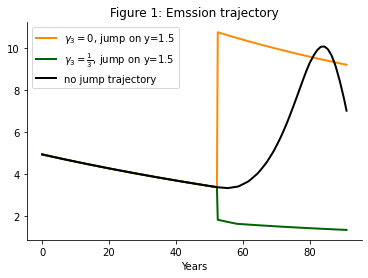

In [32]:
T = 91
time_periods = np.arange(0, T+τ, τ)
plt.plot(time_periods, et_paths[0][:int(T/τ)+1], color='darkorange', linewidth='2', label=r'$\gamma_3 = 0$, jump on y=1.5')
plt.plot(time_periods, et_paths[n_model-1][:int(T/τ)+1], color='darkgreen', linewidth='2', label=r'$\gamma_3 = \frac{1}{3}$, jump on y=1.5')
plt.plot(time_periods, et_no_jump, color='black', linewidth='2', label='no jump trajectory')
plt.legend()
plt.title('Figure 1: Emssion trajectory')
plt.xlabel('Years')
# plt.savefig('fig_1.pdf')

In [ ]:
plt.plot(model_res['y_grid'], e_grid_no_jump)

In [ ]:
plt.plot(model_res['y_grid'], np.average(np.exp(-1./ξ_p*ϕ_m), weights=πd_o, axis=0))

In [ ]:
# Compute no jump probability
no_jump_prob = np.ones_like(yt_no_jump)
for t in range(no_jump_prob.shape[0]):
    y = yt_no_jump[t]
    if y > y_bar_lower:
#         intensity = - r0 * (np.exp(- r1 / 2. * (y-y_bar_lower)**2) - 1.)
        intensity = 0.75 * (y - 1.5) * (y > 1.5)\
                    + 300 * (y - 1.9)**2 * (y > 1.9)
        no_jump_prob[t] = (1 - intensity*τ) * no_jump_prob[t-1]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(time_periods, yt_no_jump, linewidth=2.)
ax1.plot(time_periods, np.ones_like(yt_no_jump)*1.5, linestyle='dashed', color='black', linewidth=2)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_title(r'Temperature anomaly')
ax1.set_ylim(1, 2)

ax2.plot(time_periods, no_jump_prob, linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_title(r'No jump probability')
ax2.set_ylim(0, 1.05)

fig.suptitle('Figure 2')

fig.savefig('fig_2.pdf')

In [ ]:
yt_no_jump[int(54/0.25)]

In [ ]:
# Implied distorted probabilities
yt_loc = find_nearest_value(model_res['y_grid'], yt_no_jump[int(T/τ)])

Gt_m = model_res['g'][:, yt_loc]
πd = Gt_m*πd_o / np.sum(Gt_m*πd_o)
plt.hist(γ_2p, weights=πd, bins=20)
plt.xlabel(r'$\gamma_3$')
plt.title(r'Figure 1: Histogram of $\gamma_3$, weighted by distorted probabilities (Year ' + str(T) + ')')
# plt.savefig('fig_1.pdf')

In [ ]:
np.unique(et_paths[:, int(T/τ)]).shape

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.hist(et_paths[:, int(T/τ)], weights=paths_prob, bins=50)
ax1.set_title('Histogram of emission, Year '+str(T))

ax2.hist(yt_paths[:, int(T/τ)], weights=paths_prob, bins=50)
ax2.set_title('Histogram of temperature anomaly, Year '+str(T))

fig.suptitle(r'Figure 3: $\tau=0.25$')
fig.savefig('fig_3.pdf')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.hist(et_paths_1[:, int(T/1.)], weights=paths_prob_1, bins=50)
ax1.set_title('Histogram of emission, Year '+str(T))

ax2.hist(yt_paths_1[:, int(T/1.)], weights=paths_prob_1, bins=50)
ax2.set_title('Histogram of temperature anomaly, Year '+str(T))

fig.suptitle(r'Figure 4: $\tau=1$')
fig.savefig('fig_4.pdf')